# Purpose

This notebook serves as a documentation of my work through Chapter 10 of [Hands-on Machine Learning with Scikit-Learn, Keras & Tensorflow](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1491962291).  This chapter is an introduction to Artificial Neural Networks (ANN) using Keras and Tensorflow.

# Playground

First and foremost, the [Tensorflow Playground](https://playground.tensorflow.org) is a great place to gain some intuition about how ANNs work.  You can change hyperparameters live and see the effect in real time on the output, training, loss, etc.  You can also view each individual weight and output.  

In [1]:
import tensorflow as tf
from tensorflow import keras

print("tf version:", tf.__version__, ", keras version:", keras.__version__)



2023-02-04 21:23:11.935393: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


tf version: 2.10.0 , keras version: 2.10.0


# Dataset

The [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset will be used throughout all classification examples below.  It is a collection of clothing images that belong to 10 different classes.  It is similar to the more common [MNIST](http://yann.lecun.com/exdb/mnist/) dataset, except it is more complex than hand-written images.  It can be loaded directly from `keras`.

Below, Im loading the dataset, splitting off a validation set, and normalizing the values.  Then, I'm defining the classes and printing out 4 random examples of each class.

In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

print("Train shape: ", X_train.shape, ", data type: ", X_train.dtype)
print("Valid shape: ", X_valid.shape, ", data type: ", X_valid.dtype)
print("Test shape: ", X_test.shape, ", data type: ", X_test.dtype)



Train shape:  (55000, 28, 28) , data type:  float64
Valid shape:  (5000, 28, 28) , data type:  float64
Test shape:  (10000, 28, 28) , data type:  uint8


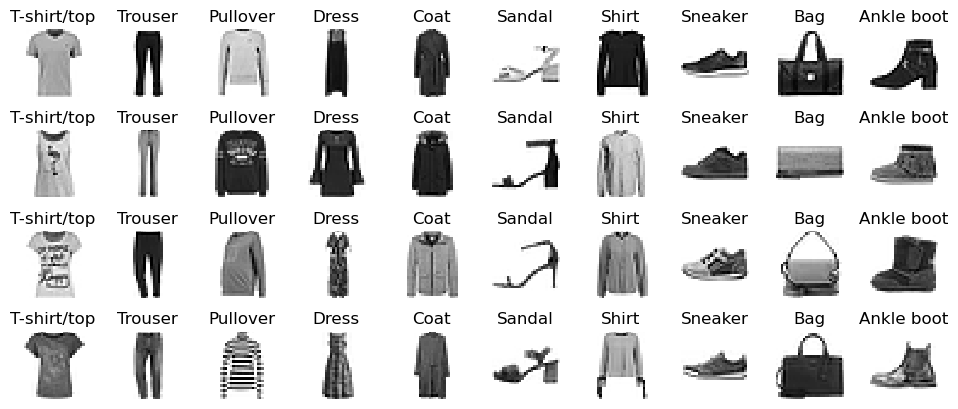

In [3]:
import matplotlib.pyplot as plt
import numpy as np

class_names = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

n_rows = 4
n_cols = len(class_names)
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        fig_index = n_cols * row + col + 1
        class_index = col
        X_subset = X_train[y_train == class_index]
        plt.subplot(n_rows, n_cols, fig_index)
        plt.imshow(
            X_subset[np.random.choice(X_subset.shape[0]), :],
            cmap="binary",
            interpolation="nearest",
        )
        plt.axis("off")
        plt.title(class_names[class_index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


# Implementing MLPs in Keras

## Image Classifier using Sequential API

### Define Layers and Connections

Here we will build a model using the sequential API, which is the simplest method of building an ANN using `keras`.  As it's name suggests, you simply define each layer sequentially to build the network from start to finish, defining the type of layer, number of nodes, and activation function for each.  The model below begins with a `Flatten` layer which simply takes the 28 x 28 images and flatten them down into 1-d.  The next three layers are `Dense` meaning they are fully connected.  The final layer uses a softmax activation because the final classes are exclusive.

In [4]:
model = keras.models.Sequential(
    [
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(300, activation="relu"),
        keras.layers.Dense(100, activation="relu"),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


2023-02-04 21:23:23.546100: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Notice that the first layer has 235,500 parameters which is (28 * 28) * 300 connection weights plus 300 bias terms.  Dense layers have many parameters because they're fully connected which makes them very flexible but also prone to overfitting.  All layer information is available by accessing the layer directly, as seen below.  Notice the weights are initilized randomly which is necessary to break symmetry.  The initialization method can be changed by setting the `kernal_initializer`.  If the input shape is not specified when building the model above, then the shape of the weight matrix is not known and Keras will not initialize the weights until it knows the input shape. 

In [5]:
hidden1 = model.layers[1]
weights, biases = hidden1.get_weights()
print(
    f"""
layer name: {hidden1.name}
first 20 weights: {weights[0:20,0]}
weights shape: {weights.shape}
first 20 biases: {biases[0:20]}
biases shape: {biases.shape}
"""
)




layer name: dense
first 20 weights: [ 0.06520967 -0.06054721 -0.04846388 -0.01210823  0.0472394  -0.04608245
 -0.05522193 -0.0516374  -0.02196507 -0.02481442 -0.03486899  0.04869628
  0.01937039  0.06310323  0.06778927 -0.05874892  0.05785915 -0.04642152
 -0.02147323  0.04915803]
weights shape: (784, 300)
first 20 biases: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
biases shape: (300,)



### Compile the Model

Now I need to compile the model and specify the loss function, optimizer, and any additional metrics to be evaluated during training.  Note that it's important to tune the learning rate, so usually you'd want to specify it when compiling, e.g. `optimizer=keras.optimizers.SGD(lr=???)` and not simply use the default value of 0.01.

In [6]:
model.compile(
    loss="sparse_categorical_crossentropy", optimizer="sgd", metrics=["accuracy"]
)


### Train and Evaluate the Model

Training the model is as simple as calling the `fit` method along with supplying the training data, validation data, and number of training epochs.  Instead of supplying the validation set, you could also set `validation_split` to the desired ratio.  

In [7]:
history = model.fit(X_train, y_train, epochs=30, validation_data=[X_valid, y_valid])


Epoch 1/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.7050 - accuracy: 0.7690 - val_loss: 0.5152 - val_accuracy: 0.8284
Epoch 2/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4855 - accuracy: 0.8327 - val_loss: 0.4466 - val_accuracy: 0.8482
Epoch 3/30
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4404 - accuracy: 0.8460 - val_loss: 0.4151 - val_accuracy: 0.8586
Epoch 4/30
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4126 - accuracy: 0.8559 - val_loss: 0.4112 - val_accuracy: 0.8552
Epoch 5/30
1719/1719 [==============================] - 7s 4ms/step - loss: 0.3914 - accuracy: 0.8618 - val_loss: 0.3756 - val_accuracy: 0.8706
Epoch 6/30
1719/1719 [==============================] - 8s 5ms/step - loss: 0.3760 - accuracy: 0.8670 - val_loss: 0.3807 - val_accuracy: 0.8648
Epoch 7/30
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3629 - accuracy: 0.8724 - val_loss: 0.3654 - val_accuracy:

The `fit` method returns a history object which contains the metrics evaluated per epoch, among other things.  Below, I'll use it to plot the learning curve to evaluate the model.  In this case, it looks like the model has not yet converged, as the loss appears to be still declining so I'd run the `fit` method again to train through some more epochs.  Here is where I would also tune hyperparameters to further improve model performance, including at least the following:
- learning rate
- optimizer
- number of layers
- number of neurons per layer
- activation functions per layer
- batch size

It's also important to re-tune the learning rate after changing any other hyperparameters. For the sake of this simple example, however, I won't proceed with any tuning.

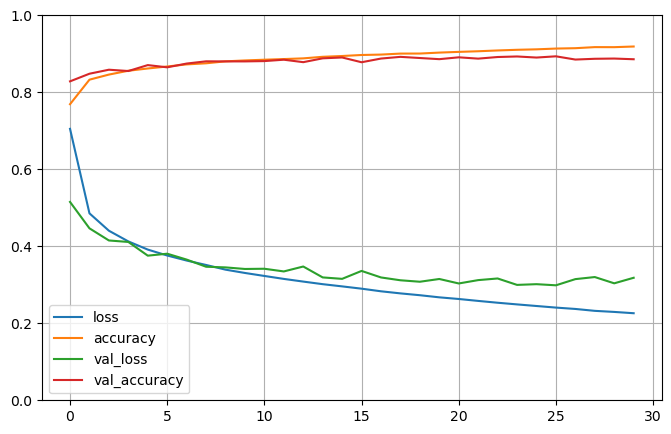

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


To evaluate on the test set, simply use the `evaluate` method.

In [9]:
model.evaluate(X_test, y_test)


313/313 [==============================] - 1s 2ms/step - loss: 68.4697 - accuracy: 0.8408


[68.46965789794922, 0.8407999873161316]

### Predict

To predict on new examples, simply use the `predict` method.  We don't have any new examples to predict on, so I'll just use the first three examples from the test set below.  In this case, the model predicted all three classes correctly.

In [10]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(5)


1/1 [==============================] - 0s 89ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [11]:
y_pred = np.argmax(y_proba, axis=1)
np.array(class_names)[y_pred]


array(['Ankle boot', 'Coat', 'Trouser'], dtype='<U11')

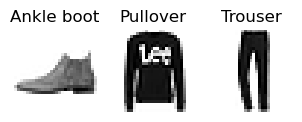

In [12]:
n_cols = X_new.shape[0]
plt.figure(figsize=(1.2 * n_cols, 1.2))
for col in range(n_cols):
    plt.subplot(1, n_cols, col + 1)
    plt.imshow(X_new[col], cmap="binary", interpolation="nearest")
    plt.axis("off")
    plt.title(class_names[y_test[col]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()


## Regression MLP Using the Sequential API

Now I'm going to use the sequential API to build a regression MLP using the California Housing dataset, loaded from `sklearn`.  The main differences for the regression task include:
- Output layer is a single neuron since the MLP will be predicting a single value
- Output layer uses no activation function since the values should be unbounded
- Loss function is mean squared error
- To reduce the risk of overfitting, I'll use a single hidden layer with fewer neurons than before



In [13]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target
)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)

housing.feature_names


['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

In [14]:
pd.DataFrame(X_train, columns=housing.feature_names).describe()


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,11610.000000,11610.000000,11610.000000,11610.000000,11610.000000,11610.000000,11610.000000,11610.000000
mean,3.857509,28.539707,5.442767,1.098576,1434.095521,2.943884,35.631671,-119.560127
std,1.886109,12.590266,2.481406,0.443130,1172.253206,1.144311,2.134862,2.004618
min,0.499900,2.000000,1.000000,0.444444,3.000000,0.750000,32.550000,-124.300000
25%,2.564550,18.000000,4.450000,1.006253,787.000000,2.430380,33.930000,-121.760000
50%,3.533000,28.000000,5.240585,1.048951,1168.000000,2.825240,34.260000,-118.500000
75%,4.721600,37.000000,6.037328,1.099760,1725.000000,3.287277,37.720000,-118.000000
max,15.000100,52.000000,141.909091,25.636364,35682.000000,63.750000,41.950000,-114.310000


In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)


In [16]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dense(1),
    ]
)
model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))



Epoch 1/20
363/363 [==============================] - 1s 3ms/step - loss: 0.7305 - val_loss: 0.4863
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4426 - val_loss: 0.7751
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4063 - val_loss: 0.4975
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3902 - val_loss: 0.4141
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3823 - val_loss: 0.4360
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3726 - val_loss: 0.3797
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3682 - val_loss: 0.3767
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3668 - val_loss: 0.4223
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3646 - val_loss: 0.3788
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3583 - val_loss: 0.3769

In [17]:
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

print("Test MSE: ", round(mse_test, 4))


1/1 [==============================] - 0s 44ms/step
Test MSE:  0.413


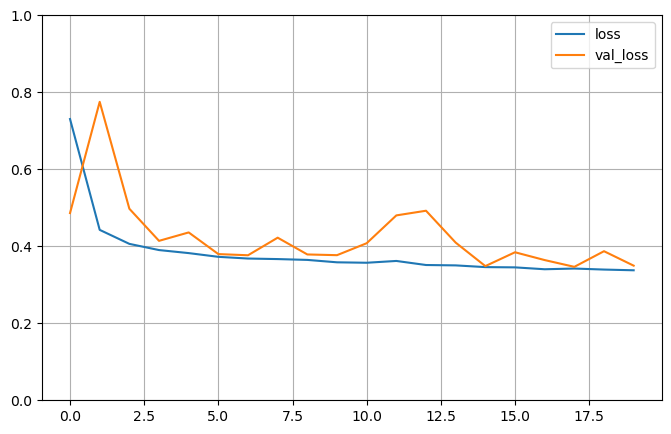

In [18]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


## Building More Complex Models Using the Functional API

To build a model that is not sequential, you have to use the funcitonal API.  Here, I'll build one such non-sequential model, the [Wide & Deep](https://arxiv.org/abs/1606.07792) neural network, which connects all or part of the input directly to the output layer.  This is intended to train simple rules in addition to the deep patterns.  A sequential MLP forces all data through each layer, which could then distort simple rules.  I'll revisit the above regression model on the California housing dataset.

The steps of constructing the model look a bit different with the functional API and so I'll explain each line here:
1.  Create an input object with defined input shape, using `input_` to avoid overwriting the built in python `input()` function.
2.  Define the first hidden layer, a dense layer with 30 neurons, RELU activation function, and pass it the preceeding layer `input_` like a function, e.g. functional API.
3.  Define the second hidden layer, also a dense layer with 30 neurons, RELU acitvation function, and pass it the preceeding layer `hidden1`.
4.  Create a concatenate layer to concatenate the input with the output of the second hidden layer.  This is the wide & deep part.
5.  Create an output layer with a single nueron and no activation function.
6.  Create a `keras` model by supplying the inputs and outputs as defined above.



In [19]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(10, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([input_, hidden2])
output = keras.layers.Dense(1)(concat)
model = keras.Model(inputs=[input_], outputs=[output])


In [20]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=0.004))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))


Epoch 1/20


/Users/mcnewcp/code/ann-intro/.env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


363/363 [==============================] - 1s 1ms/step - loss: 0.9999 - val_loss: 0.5687
Epoch 2/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4960 - val_loss: 0.4781
Epoch 3/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4408 - val_loss: 0.4395
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4145 - val_loss: 0.4234
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3993 - val_loss: 0.4100
Epoch 6/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3909 - val_loss: 0.4136
Epoch 7/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3838 - val_loss: 0.4128
Epoch 8/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3796 - val_loss: 0.4065
Epoch 9/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3744 - val_loss: 0.4318
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.3712 - val_loss: 0.3743
Epoch 11/2

In [21]:
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

print("Test MSE: ", round(mse_test, 4))


1/1 [==============================] - 0s 52ms/step
Test MSE:  0.3526


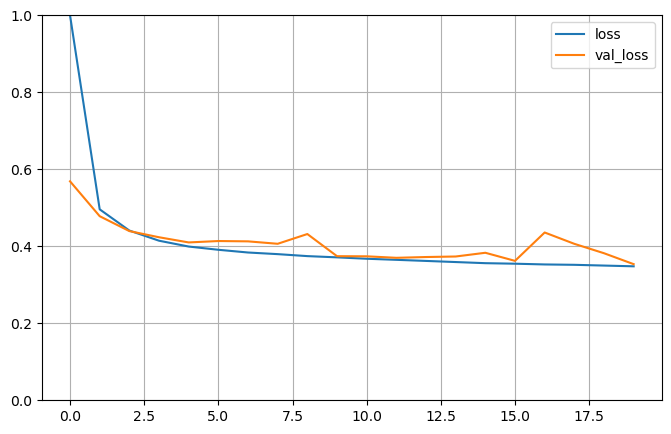

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


### Multiple Inputs

It is also possible to supply multiple inputs to the model if you wanted to, for example, send a subset of features through the wide path and a different subset (possibly overlapping) subset through the deep path, it's as simple as defining those inputs and applying accordingly.  

Here, I'll modify the above model to use two overlapping subsets of inputs.  The first subset (`input_A`, features 1-5) will go through the wide path and the second subset (`input_B`, features 4-8) will go through the deep path.  It's also good practice to name at least the important layers for clarity.


In [23]:
input_A = keras.layers.Input(shape=X_train[:, :5].shape[1:], name="wide_input")
input_B = keras.layers.Input(shape=X_train[:, 4:].shape[1:], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(10, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([hidden2, input_A])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.Model(inputs=[input_A, input_B], outputs=[output])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))



Since the model is designed to look for `[input_A, input_B]`, when calling the fit method, the training data will need to be supplied in a tuple format, e.g. `(X_train_A, X_train_B)`. The same is true for the validation, test, and predictions sets.

Epoch 1/20
363/363 [==============================] - 1s 2ms/step - loss: 2.0369 - val_loss: 1.7083
Epoch 2/20
363/363 [==============================] - 1s 1ms/step - loss: 0.7236 - val_loss: 0.7716
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.6171 - val_loss: 0.6177
Epoch 4/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5811 - val_loss: 0.5815
Epoch 5/20
363/363 [==============================] - 0s 1ms/step - loss: 0.5530 - val_loss: 0.5581
Epoch 6/20
363/363 [==============================] - 1s 1ms/step - loss: 0.5300 - val_loss: 0.5405
Epoch 7/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5103 - val_loss: 0.5196
Epoch 8/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4950 - val_loss: 0.5170
Epoch 9/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4820 - val_loss: 0.5140
Epoch 10/20
363/363 [==============================] - 0s 1ms/step - loss: 0.4718 - val_loss: 0.4912

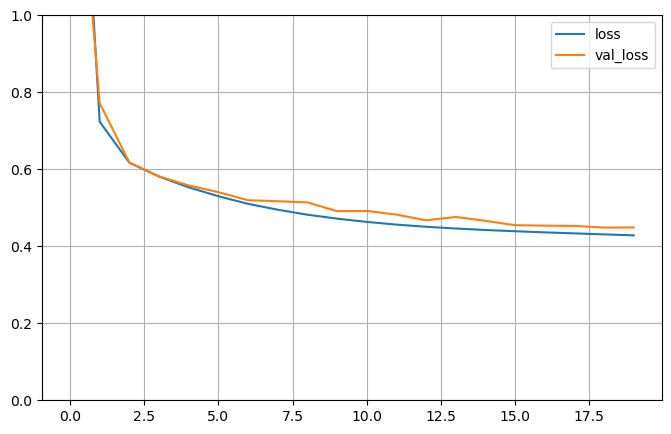

In [24]:
X_train_A, X_train_B = X_train[:, :5], X_train[:, 4:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 4:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 4:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit(
    (X_train_A, X_train_B),
    y_train,
    epochs=20,
    validation_data=((X_valid_A, X_valid_B), y_valid),
)

mse_test = model.evaluate((X_test_A, X_test_B), y_test)
y_pred = model.predict((X_new_A, X_new_B))
print("Test MSE: ", round(mse_test, 4))

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


### Multiple Outputs

There are a number of scenarios where predicting multiple outputs would be beneficial.  
- The most obvious to me include simultaneously locating and classifying one or more objects within a picture.  This would include a regressiont task with one output each for the x and y position, along with a classification of the object.  
- You could of course need to predict multiple targets from the same dataset, like more than one trait from a genetic dataset.  
- Another use case mentioned by the authors of [Hands on ML](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) is to use an additional output as a regularization technique.  For example, in the above model we could add an auxiliary output from the deep path only, which would be trained on the same target as the main output.  This would ensure that the deep path actually learns something on it's own, independent of the rest of the network, and therefore allow the model to generalize better.  

Adding additional outputs is quite simple, following the example above.


In [25]:
input_A = keras.layers.Input(shape=X_train[:, :5].shape[1:], name="wide_input")
input_B = keras.layers.Input(shape=X_train[:, 4:].shape[1:], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(10, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([hidden2, input_A])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])


#### Losses and Weighted Loss

Each output needs to be assigned a loss function, which in our example will be MSE for both.  By default Keras will simply add the losses together to get our overall loss, but in our case we care more about the loss associated with the main output than that of the auxiliary output.  Conveniently, we can pass a list of weights for the outputs when compiling the model.  In this case we will pass `loss_weights[0.9, 0.1]` to inform Keras that we care about the main output much more than the auxiliary.

In [26]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer="sgd")



#### Train, Evaluate, Test

During training we need to supply a target for each of the outputs.  Since the outputs in our example are predicting the same thing, I'll supply `y_train` to both.  Similarly, I'll provide both `y_valid` and `y_test` during evaluation and testing, respectively.

Upon testing, keras will return the total loss as well as the invidual losses for each output.

And of course the `predict` method will provide predictions for each output.

Epoch 1/20
363/363 [==============================] - 2s 2ms/step - loss: 0.8876 - main_output_loss: 0.7705 - aux_output_loss: 1.9415 - val_loss: 0.8691 - val_main_output_loss: 0.7681 - val_aux_output_loss: 1.7776
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5129 - main_output_loss: 0.4437 - aux_output_loss: 1.1356 - val_loss: 0.5587 - val_main_output_loss: 0.4300 - val_aux_output_loss: 1.7167
Epoch 3/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4803 - main_output_loss: 0.4212 - aux_output_loss: 1.0121 - val_loss: 0.6411 - val_main_output_loss: 0.5689 - val_aux_output_loss: 1.2910
Epoch 4/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4667 - main_output_loss: 0.4142 - aux_output_loss: 0.9394 - val_loss: 0.6067 - val_main_output_loss: 0.5438 - val_aux_output_loss: 1.1729
Epoch 5/20
363/363 [==============================] - 1s 1ms/step - loss: 0.4580 - main_output_loss: 0.4088 - aux_output_loss: 0.9008 - val_loss

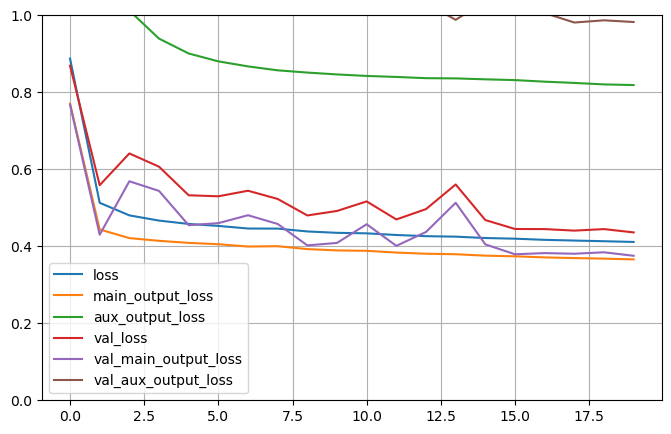

In [27]:
history = model.fit(
    [X_train_A, X_train_B],
    [y_train, y_train],
    epochs=20,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]),
)

total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
print(
    f"""
Total MSE: {round(total_loss, 4)}
Main Loss: {round(main_loss, 4)}
Aux Loss : {round(aux_loss, 4)}
"""
)

y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


## Subclassing API for Dynamic Models

The final and most advanced way to design your model is to subclass the model class, which allows you to separate the creation of the layers in `__init__()` from their usage in the `call()` method.  This allows you to build any sort of dynamic behavior into the call method, e.g. for loops, if statements.

In [28]:
class WideAndDeepModel(keras.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)  # passes standard args, e.g. name
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)

    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.Concatenate()([hidden2, input_A])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output


model = WideAndDeepModel()


### Compile and Train

Compiling and training the model then proceed exactly as before.

Epoch 1/20
363/363 [==============================] - 2s 3ms/step - loss: 0.9216 - output_1_loss: 0.8361 - output_2_loss: 1.6911 - val_loss: 0.6711 - val_output_1_loss: 0.5339 - val_output_2_loss: 1.9058
Epoch 2/20
363/363 [==============================] - 1s 2ms/step - loss: 0.5004 - output_1_loss: 0.4397 - output_2_loss: 1.0470 - val_loss: 0.7301 - val_output_1_loss: 0.6663 - val_output_2_loss: 1.3040
Epoch 3/20
363/363 [==============================] - 1s 3ms/step - loss: 0.4711 - output_1_loss: 0.4173 - output_2_loss: 0.9546 - val_loss: 0.5206 - val_output_1_loss: 0.4644 - val_output_2_loss: 1.0272
Epoch 4/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4589 - output_1_loss: 0.4085 - output_2_loss: 0.9125 - val_loss: 0.5525 - val_output_1_loss: 0.5032 - val_output_2_loss: 0.9963
Epoch 5/20
363/363 [==============================] - 1s 2ms/step - loss: 0.4580 - output_1_loss: 0.4103 - output_2_loss: 0.8873 - val_loss: 0.8811 - val_output_1_loss: 0.8633 - val_ou

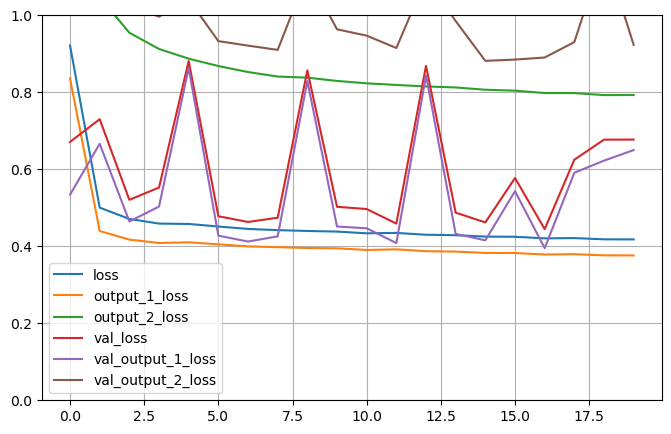

In [29]:
model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer="sgd")

history = model.fit(
    [X_train_A, X_train_B],
    [y_train, y_train],
    epochs=20,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]),
)

total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
print(
    f"""
Total MSE: {round(total_loss, 4)}
Main Loss: {round(main_loss, 4)}
Aux Loss : {round(aux_loss, 4)}
"""
)

y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


### Tradeoffs

The main __advantage__ of the subclassing method comes from the ability to build any complex architecture that you want.  This is likely most valuable to researchers trying out new ideas.  The main __disadvantage__ is the other side of that coin - since the model is so dynamic it's difficult to interpret.  Since the architecture is hidden within the `call()` method, Keras can't inspect it, not to mention you can't save or clone the model.  In addition, the funcitonal and sequential API allow for Keras to check types and shapes ahead of time, catching errors before compiling and fitting.  In general, it seems the subclass method should be reserved for when you absolutely need the architectural flexibility.

## Saving and Loading Models

For models created using the sequential or functional API, saving and loading is quite simple.  To save, you just use the `save()` method of the model.  To load you use `keras.models.load_model()`.  Below, I'll rebuild the sequential model from above to illustrate how this works.


In [30]:
model = keras.models.Sequential(
    [
        keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
        keras.layers.Dense(1),
    ]
)
model.compile(loss="mean_squared_error", optimizer="sgd")
history = model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))


Epoch 1/5
363/363 [==============================] - 1s 1ms/step - loss: 0.7727 - val_loss: 0.5138
Epoch 2/5
363/363 [==============================] - 0s 1ms/step - loss: 0.4259 - val_loss: 0.5525
Epoch 3/5
363/363 [==============================] - 1s 1ms/step - loss: 0.4010 - val_loss: 0.4555
Epoch 4/5
363/363 [==============================] - 0s 1ms/step - loss: 0.3900 - val_loss: 0.6798
Epoch 5/5
363/363 [==============================] - 0s 1ms/step - loss: 0.3840 - val_loss: 0.4090


In [33]:
model.save("mods/my_keras_reg.h5")

loaded_model = keras.models.load_model("my_keras_reg.h5")
loaded_model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 30)                270       
                                                                 
 dense_17 (Dense)            (None, 1)                 31        
                                                                 
Total params: 301
Trainable params: 301
Non-trainable params: 0
_________________________________________________________________


## Using Callbacks

The `fit()` method accepts a list of callbacks which will be called at a specified interval throughout training.  There are quite a few built in [callbacks provided by Keras](https://keras.io/api/callbacks/) and you can also write your own.  The callbacks which seem most obviously useful to me include:
- ModelCheckpoint saves your model after each epoch.  You can also supply `save_best_only=True` and a checkpoint will only be saved if the epoch resulted in the best validation score during training so far.
- EarlyStopping stops training when the validation fails to decline for a set number of epochs, defined by the `patience` parameter.
- TensorBoard provides information to the interactive visualization tool to track and view training.  This is covered in the next section.

Below I'll fit the regression MLP from above with an early stopping callback and I'll save a checkpoint at each epoch.


In [32]:
input_A = keras.layers.Input(shape=X_train[:, :5].shape[1:], name="wide_input")
input_B = keras.layers.Input(shape=X_train[:, 4:].shape[1:], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(10, activation="relu")(hidden1)
concat = keras.layers.Concatenate()([hidden2, input_A])
output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

model.compile(loss=["mse", "mse"], loss_weights=[0.9, 0.1], optimizer="sgd")


In [34]:
my_callbacks = [
    keras.callbacks.EarlyStopping(patience=4),
    keras.callbacks.ModelCheckpoint(filepath='mods/model.{epoch:02d}-{val_loss:.2f}.h5')
]

history = model.fit(
    [X_train_A, X_train_B],
    [y_train, y_train],
    epochs=50,
    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]),
    callbacks = my_callbacks
)


Epoch 1/50
363/363 [==============================] - 2s 3ms/step - loss: 0.9395 - main_output_loss: 0.8055 - aux_output_loss: 2.1450 - val_loss: 0.5880 - val_main_output_loss: 0.5025 - val_aux_output_loss: 1.3580
Epoch 2/50
363/363 [==============================] - 1s 3ms/step - loss: 0.4931 - main_output_loss: 0.4382 - aux_output_loss: 0.9871 - val_loss: 0.5276 - val_main_output_loss: 0.4504 - val_aux_output_loss: 1.2220
Epoch 3/50
363/363 [==============================] - 1s 2ms/step - loss: 0.4645 - main_output_loss: 0.4138 - aux_output_loss: 0.9206 - val_loss: 0.5235 - val_main_output_loss: 0.4589 - val_aux_output_loss: 1.1049
Epoch 4/50
363/363 [==============================] - 1s 2ms/step - loss: 0.4546 - main_output_loss: 0.4066 - aux_output_loss: 0.8860 - val_loss: 0.4975 - val_main_output_loss: 0.4292 - val_aux_output_loss: 1.1121
Epoch 5/50
363/363 [==============================] - 1s 2ms/step - loss: 0.4473 - main_output_loss: 0.4006 - aux_output_loss: 0.8683 - val_loss

162/162 [==============================] - 0s 2ms/step - loss: 0.7980 - main_output_loss: 0.6956 - aux_output_loss: 1.7194

Total MSE: 0.798
Main Loss: 0.6956
Aux Loss : 1.7194



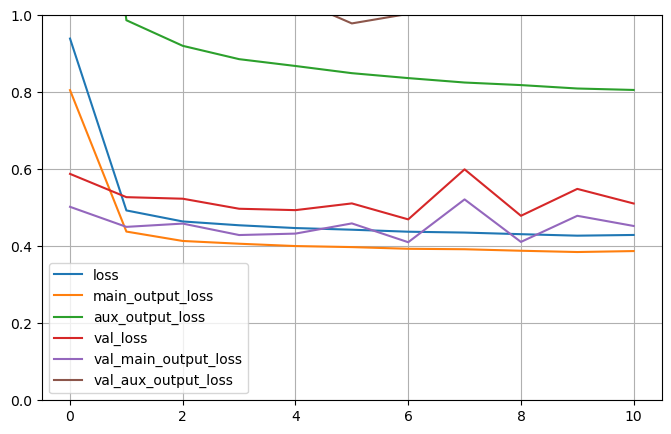

In [35]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test])
print(
    f"""
Total MSE: {round(total_loss, 4)}
Main Loss: {round(main_loss, 4)}
Aux Loss : {round(aux_loss, 4)}
"""
)

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()


# TensorBoard

[TensorBoard](https://www.tensorflow.org/tensorboard) is a tool built to work directly with TensorFlow models which performs a number of useful tasks during model, training, tuning, evaluation.  Here are a few of them, taken directly from the [TensorBoard site](https://www.tensorflow.org/tensorboard):

- Tracking and visualizing metrics such as loss and accuracy
- Visualizing the model graph (ops and layers)
- Viewing histograms of weights, biases, or other tensors as they change over time
- Projecting embeddings to a lower dimensional space
- Displaying images, text, and audio data

It does all of this by tracking special log files using the keras callback [keras.callbacks.TensorBoard()](https://keras.io/api/callbacks/tensorboard/).  You just have to supply it with a directory of where to store the log.  You then supply TensorBoard with the root log directory so that it can track runs in real time.  It's best practice to store each run in a subdirectory so that you can visualize runs separately in TensorBoard.

## Log Directory

I'll start by defining a function below which will generate a new subdirectory for each run using the datetime and a couple manually defined hyperparameters.

In [47]:
import os
import time

root_logdir = os.path.join(os.curdir, "tb_log")

def get_run_logdir(learning_rate, n_neurons):
    run_time = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    run_hps = f"{learning_rate}_{n_neurons}_"
    return os.path.join(root_logdir, run_hps + run_time)


## Using the Callback

Now I'll take a regression example from above and wrap it in a function so that I can easily change the two hyperparameters I pulled out above.  

In [48]:
def get_reg_model(learning_rate, n_neurons):
    input_A = keras.layers.Input(shape=X_train[:, :5].shape[1:], name="wide_input")
    input_B = keras.layers.Input(shape=X_train[:, 4:].shape[1:], name="deep_input")
    hidden1 = keras.layers.Dense(n_neurons, activation="relu")(input_B)
    hidden2 = keras.layers.Dense(n_neurons, activation="relu")(hidden1)
    concat = keras.layers.Concatenate()([hidden2, input_A])
    output = keras.layers.Dense(1, name="main_output")(concat)
    aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)
    model = keras.Model(inputs=[input_A, input_B], outputs=[output, aux_output])

    model.compile(
        loss=["mse", "mse"],
        loss_weights=[0.9, 0.1],
        optimizer=keras.optimizers.SGD(learning_rate=learning_rate),
    )
    return model



Now when I run the `fit()` method below I'll provide the relevant TensorBoard callback and Keras will create the subdirectory and generate the logs.

I'll run through a few combinations of hyperparameters so I have something to look at in TensorBoard.

In [52]:
for learning_rate in [0.001, 0.01]:
    for n_neurons in [2, 3, 5]:
        run_logdir = get_run_logdir(learning_rate, n_neurons)
        tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
        my_mod = get_reg_model(learning_rate, n_neurons)
        history = my_mod.fit(
            [X_train_A, X_train_B],
            [y_train, y_train],
            epochs=30,
            validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]),
            callbacks=tensorboard_cb,
            verbose=0,
        )


## Using the TensorBoard Tool

Now to run TensorBoard locally, simply call in the terminal and supply the root log directory.

```zsh
% tensorboard --logdir=./tb_log --port=6006
```

Now by going to the Scalars section you can view all learning curves in real time, for each run, output, training, and validation.  

![TensorBoard Screenshot](images/tensorboard_sn.png)

## Conclusions

TensorBoard looks like a very useful tool.  You can view real time learning curves with minimal effort.  It also seems to be way more powerful and able to track nearly anything you want using the `tf.summary` package along with `create_file_writer()`.  

The way I used it above to investigate a small hyperparameter space was quite manual and inefficient, though I was only scratching the surface of what it's capable of.  It looks like hyperparameters need to be tagged as such within the log generation for optimal efficiency.  I'll look more into that in the next section.

# Hyperparameter Tuning

The thing I find intimitading and opaque with regard to neural networks is also their main advantage - they are incredibly flexibile.  This means they can theoretically learn any relationship but this also means there are a plethora of decisions to be made and tweaked, e.g. network architecture, number of hidden layers, neurons per layer, activation function per layer, optimizer, weight initialization, etc.  

The purpose of this section is to explore hyperparameter tuning using TensorBoard.  First, I'll go through some recommendations [by the authors](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) on approach for the major hyperparmeters for ANNs and DL.

In addition, there is a quite complete [hyper-parameter tuning guide](https://arxiv.org/abs/1803.09820) available by Leslie Smith.

## General Guidance

### Number of Hidden Layers

A network with a single layer can supposedly learn any complex relationship, as long as the layer contains enough nuerons.  Many neurons in a layer however, greatly increases the number of connections and therefore connection weights to be fit.  A deeper network (one with more hidden layers) can achieve the same task more efficiently by using less neurons and therefore connection weights.  

As a starting point, an MLP with one or two layers can usually do a reasonable job.  Hidden layers can then be added until the model begins to overfit.  

### Neurons per Hidden Layer

It used to be convention to form networks as a pyramid, with the number of neurons per layer decreasing throughout.  It now seems it's more common for there to be the same number of neurons for each layer, if for no other reason than it reduces the number of hyperparameters to tune.  

Similar to number of hidden layers, the number of neurons per layer can be increased until the model begins to overfit.  In practice it seems that the most data scientists simply use more layers and neurons than they need and then use early stopping and regularization techniques to keep from overfitting.  In general though, it's more efficient to increase the number of layers than the number of neurons.

### Learning Rate

A good technique for choosing learning rate is to start very small (e.g. $10^{-5}$) and train for a couple hundred epochs.  Then iteratively increase the learning rate logarithmically and repeat the process, finally plotting loss as a function of learning rate.  Choose a learning rate well below where the model diverges, i.e. where the loss increases, and retrain using the chosen learning rate.

The learning rate depends on other hyperparameters, especially the batch size, so if any other are changed, the learning rate needs to be tuned again.

### Optimizer

There are many [optimizers](https://keras.io/api/optimizers/) built in to keras, some of which are more efficient than the default mini-batch gradient descent, though exploration of those is outside the scope of this notebook.

### Batch size

The main benefit of using a larger batch size is that modern GPUs can process larger batches efficiently, allowing the algorithm to see more samples per timestep.  There is disagreement among the community on whether small or large batch size is best. A [2018 paper](https://arxiv.org/abs/1804.07612) suggested that small batch sizes (2 - 32) resulted in better models in less training time, while a couple papers in 2017 ([1](https://arxiv.org/abs/1705.08741), [2](https://arxiv.org/abs/1706.02677)) suggested that using very large batch sizes (up to 8,192) with other techinques such as learning rate warm up led to a very short training time with no generalization gap.

The authors of Hand on ML suggest starting with a large batch size and learning rate warm up, then if training is unstable or the final performance is poor, reduce the batch size.

### Activation function

In general, ReLU is a good default choice for hidden layers, though this can be tuned as well.  Keras offers several options [built in](https://keras.io/api/layers/activations/).

### Number of iterations

In general, the number of iterations should not be tuned, but rather use early stopping instead.



## Tools

### Functionalize Model

The first step before tuning hyperparameters is to separate the hyperparameters from the model build code so that we can vary the hyperparameters each time we build the model.

In [63]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(learning_rate=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model



### sklearn wrapper

Keras provides a wrapper which trasnforms the model into a `sklearn` object, which allows it to be used like any other `sklearn` model.  When calling methods of the the model this way, any extra parameters are passed to the underlying keras model, e.g. `epochs=100`, `callbacks=[]`, etc.  Below, I'll illustrate using the `fit()` method with the default hyperparameters.

It looks like since the publication of this book, the wrapper is being deprecated in preference of a separate package called [`scikeras`](https://github.com/adriangb/scikeras).  I won't cover it here, but it looks like the authors produced a [guide for switching](https://www.adriangb.com/scikeras/stable/migration.html).

In [64]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

keras_reg.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
    verbose=0,
)

mse_test = keras_reg.score(X_test, y_test)
y_pred = keras_reg.predict(X_new)

print("Test MSE = ", round(mse_test, 4))



/var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/ipykernel_13923/837531928.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


1/1 [==============================] - 0s 50ms/step
Test MSE =  -0.3841


#### Randomized Search CV

Since the model is an `sklearn` model object, we can make use of other tools from that package as well, including `RandomizedSearchCV` to explore a larger hyperparameter space.  Below, I'll set it up to randomly sample a large hyperparameter space for 20 iterations, using 3 folds.  In this case, since the search is using cross-validation, the validation set supplied (`X_valid`, `y_valid`) is used only for early stopping.  


In [71]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

hp_space = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)
search_history = RandomizedSearchCV(keras_reg, hp_space, n_iter=20, cv=3)
search_history.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[keras.callbacks.EarlyStopping(patience=10)],
    verbose=0,
)


/var/folders/m8/0_prp1tj41s9n5xm0bfqp6wm0000gn/T/ipykernel_13923/3659664113.py:10: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)


121/121 [==============================] - 0s 1ms/step - loss: 0.3658


RandomizedSearchCV(cv=3,
                   estimator=<keras.wrappers.scikit_learn.KerasRegressor object at 0x7f79a7ba0580>,
                   n_iter=20,
                   param_distributions={'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f79a7e8b640>,
                                        'n_hidden': [0, 1, 2, 3],
                                        'n_neurons': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])})

In [72]:
best_mod = search_history.best_estimator_.model
mse_test = best_mod.evaluate(X_test, y_test)
print(
    f"Best parameters: {search_history.best_params_}\n\
    Best score: {search_history.best_score_}\n\
    Test MSE = {round(mse_test, 4)}"
)


162/162 [==============================] - 0s 2ms/step - loss: 0.2875
Best parameters: {'learning_rate': 0.010048299279975277, 'n_hidden': 3, 'n_neurons': 77}
    Best score: -0.29163694381713867
    Test MSE = 0.2875


### HP tracking in TensorBoard

TensorBoard also has built in hyperparameter tracking via the HParams dashboard.  The official documentation lists a simple but complete [tutorial](https://www.tensorflow.org/tensorboard/hyperparameter_tuning_with_hparams) that I'll summarize here.  I won't go over setting up TensorBoard and logs again, as that was covered [above](#tensorboard).  Instead I'll focus on the additional steps for tracking hyperparameters in particular.

#### Define search space

First, the search space must be defined using the `hparams.api` plugin.  The second chunk below writes the search space to the TensorBoard logging directory.  This step is optional but it does inform TensorBoard on the range of hyperparameters, which allows for some interactive filtering of values, which is nice.

In [139]:
from tensorboard.plugins.hparams import api as hp

N_HIDDEN = hp.HParam("n_hidden", hp.Discrete([0, 1, 2, 3]))
N_NEURONS = hp.HParam("n_neurons", hp.IntInterval(1,100))
LEARNING_RATE = hp.HParam("learning_rate", hp.RealInterval(3e-4, 3e-2))

METRIC_MSE = "mse"

with tf.summary.create_file_writer("tb_log/hp_tuning").as_default():
    hp.hparams_config(
        hparams=[N_HIDDEN, N_NEURONS, LEARNING_RATE],
        metrics=[hp.Metric(METRIC_MSE, display_name="mse")],
    )



#### Log values

Now I'm modifying the `build_model()` function from above to include fitting the model, returning the test score, and logging all values.  
- The TensorBoard callback is used as before, to log learning curve data for each trial.
- `hp.KerasCallback()` is used to log the hyperparameters for each trial.
-  `tf.summary.create_file_writer()` is used to log the metric associated with each trial, in this case the MSE on the test set.

In [143]:
def train_test_model(hparams, run_logdir):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=[8]))
    for layer in range(hparams[N_HIDDEN]):
        model.add(keras.layers.Dense(hparams[N_NEURONS], activation="relu"))
    model.add(keras.layers.Dense(1))

    optimizer = keras.optimizers.SGD(learning_rate=hparams[LEARNING_RATE])
    model.compile(loss="mse", optimizer=optimizer, metrics=["mse"])

    model.fit(
        X_train,
        y_train,
        epochs=100,
        validation_data=(X_valid, y_valid),
        callbacks=[
            keras.callbacks.EarlyStopping(patience=10),
            keras.callbacks.TensorBoard(run_logdir),  # log metrics
            hp.KerasCallback(run_logdir, hparams),  # log hparams
        ],
        verbose=0,
    )

    _, mse = model.evaluate(X_test, y_test)
    with tf.summary.create_file_writer(run_logdir).as_default():
        tf.summary.scalar(METRIC_MSE, mse, step=1)

    return


#### Run trials

Now I'm simply looping through 20 trials and randomly sampling each hyperparameter within each loop.  The hyperparam objects have a `sample_uniform()` method which allows for random sampling.  

In [145]:
root_logdir = os.path.join(os.curdir, "tb_log/hp_tuning/")
num_iters = 20

for iter_num in range(num_iters):
    # randomly sample hparams
    hparams = {
        N_HIDDEN: N_HIDDEN.domain.sample_uniform(),
        N_NEURONS: N_NEURONS.domain.sample_uniform(),
        LEARNING_RATE: LEARNING_RATE.domain.sample_uniform(),
    }
    run_name = f"run-{iter_num}"
    print(f"--- Starting trial: {run_name}")
    print({h.name: hparams[h] for h in hparams})
    run_logdir = os.path.join(root_logdir, run_name)

    mse = train_test_model(hparams, run_logdir)


--- Starting trial: run-0
{'n_hidden': 3, 'n_neurons': 83, 'learning_rate': 0.0008250531162652514}
162/162 [==============================] - 0s 1ms/step - loss: 0.3452 - mse: 0.3452
--- Starting trial: run-1
{'n_hidden': 3, 'n_neurons': 43, 'learning_rate': 0.01813516123141377}
162/162 [==============================] - 0s 1ms/step - loss: 0.3472 - mse: 0.3472
--- Starting trial: run-2
{'n_hidden': 2, 'n_neurons': 74, 'learning_rate': 0.02001486111327987}
162/162 [==============================] - 0s 2ms/step - loss: 0.5509 - mse: 0.5509
--- Starting trial: run-3
{'n_hidden': 3, 'n_neurons': 97, 'learning_rate': 0.02236068000287825}
162/162 [==============================] - 0s 2ms/step - loss: 1.0352 - mse: 1.0352
--- Starting trial: run-4
{'n_hidden': 3, 'n_neurons': 68, 'learning_rate': 0.004824735755219282}
162/162 [==============================] - 0s 2ms/step - loss: 0.3836 - mse: 0.3836
--- Starting trial: run-5
{'n_hidden': 3, 'n_neurons': 62, 'learning_rate': 0.00790771883094

#### Using the client

Now, similar to above, we just need to serve the TensorBoard client locally, pointing it towards the parent directory, from terminal:
```zsh
% tensorboard --logdir=./tb_log --port=6006
```
There will now be a new HPARAMS tab at the top which provides several views of the results of the tuning experiment, including tabular, parallel coordinates (shown below), and scatter plot matrix.

These views are helpful at sorting through the trials to find the best one or to find the most promising hyperparameter ranges for further investigation.  It feels rather cumbersome, however, to relate a trial from the HPARAM tab back to the TIME SERIES tab to view the learning curve, especially if the number of trials grew to be large.

![](images/tb_hp_tuning_sn.png)